In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter


In [ ]:
import os
from skimage import io

class BedroonDataset(Dataset):
  def __init__(self, dir, transform):
    self.dir = dir
    self.transform = transform
    self.len_messy = len(os.listdir(os.path.join(self.dir,"messy")))
  
  def __len__(self):
    return 2*self.len_messy

  def __getitem__(self,index):
    if index >= self.len_messy:
      img_name = os.path.join(self.dir,"clean",f'{index%(self.len_messy)}.png')
      img = io.imread(img_name)
      label = torch.tensor([float(1)])
    else:
      img_name = os.path.join(self.dir,"messy",f'{index}.png')
      img = io.imread(img_name)
      label = torch.tensor([float(0)])
    
    if self.transform:
      img = self.transform(img)
    
    return (img,label)



In [ ]:
import os
from skimage import io

class BedroonTestDataset(Dataset):
  def __init__(self, dir,transform):
    self.dir = dir
    self.transform = transform
    self.len_test = len(os.listdir(dir))
  
  def __len__(self):
    return self.len_test

  def __getitem__(self,index):
    img_name = os.path.join(self.dir,f'{index}.png')
    img = io.imread(img_name)

    if self.transform:
      img = self.transform(img)
    
    return img



In [ ]:
class AlexaNet(nn.Module):
  def __init__(self):
    super(AlexaNet,self).__init__()
    self.cov1 = nn.Conv2d(in_channels=3,out_channels=96,kernel_size=11,stride=4)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.cov2 = nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,padding=2)
    self.cov3 = nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1)
    self.cov4 = nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1)
    self.cov5 = nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1)
    self.fc0 = nn.Linear(20736,4096) 
    self.fc1 = nn.Linear(4096,4096) 
    self.fc2 = nn.Linear(4096,1)
    self.dropout = nn.Dropout2d(0.5)

  def forward(self,x):
    x = F.relu(self.cov1(x))
    x = self.pool(x)
    x = F.relu(self.cov2(x))
    x = self.pool(x)
    x = F.relu(self.cov3(x))
    x = F.relu(self.cov4(x))
    x = F.relu(self.cov5(x))
    x = self.pool(x)
    x = x.view(-1,20736)
    x = F.relu(self.fc0(x))
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = torch.sigmoid(self.fc2(x))
    return x

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet,self).__init__()
    self.cov1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1,padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.cov2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1)
    self.fc1 = nn.Linear(16*74*74,120) 
    self.fc2 = nn.Linear(120,120)
    self.fc3 = nn.Linear(120,84)
    self.fc4 = nn.Linear(84,1)
    self.dropout = nn.Dropout2d(0.25)

  def forward(self,x):
    x = F.relu(self.cov1(x))
    x = self.pool(x)
    x = F.relu(self.cov2(x))
    x = self.pool(x)
    x = x.view(-1,16*74*74)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))
    return x

In [ ]:
#test the model
model = AlexaNet()
x = torch.randn(16,3,296,296)
print(model(x).shape)

torch.Size([16, 1])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = [0.01,0.001,0.0001]
BATCH_SIZE = [8,16,32]
IMAGE_SIZE = 296
CHANNELS_IMG = 3
NUM_EPOCHS = 20
LOSS = []
classes = ("Messy","Clean")

transforms = transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

train_dataset = BedroonDataset("/content/drive/MyDrive/data/Bedroom/train",transforms)
valid_dataset = BedroonDataset("/content/drive/MyDrive/data/Bedroom/val",transforms)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, shuffle=True)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# show images
# imshow(torchvision.utils.make_grid(images))
# print(' '.join('%5s' % classes[int(labels[j])] for j in range(BATCH_SIZE)))

In [ ]:
# net = Net().to(device)

#initializing weights
# for m in net.modules():
#     if isinstance(m, (nn.Conv2d)):
#       nn.init.normal_(m.weight.data, 0.0, 0.02)

# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# criterion = nn.BCELoss()

# net.train()

In [ ]:
def check_accuracy(loader,model,show_img = False):
  correct = 0 
  samples = 0
  model.eval()

  with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(loader):
      data = data.to(device)
      targets = targets.to(device)

      output = model(data)
      output = torch.where(output>0.5,1,0)
      predicted = torch.reshape(output,(-1,))
      targets = torch.reshape(targets,(-1,))
      samples += predicted.size(0)
      correct += torch.sum(predicted == targets)
      if show_img:
        imshow(torchvision.utils.make_grid(data.cpu()))
        print(f'Predicted = {classes[int(predicted)]}, Actual = {classes[int(targets)]}')


  # print(f'\tAccuracy = {(correct/samples) *100:.2f}%, Correct = {correct}, Sample Size = {samples}')
  acc = (correct/samples) *100
  return acc 
  model.train()


In [ ]:
def train(model, lr, batch_size, epochs, optimizer_type ):

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  writer = SummaryWriter(f"logs/BS {batch_size} LR {lr} {optimizer_type}")
  step = 0 
  LOSS = []

  criterion = nn.BCELoss()
  if optimizer_type == "SGD":
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
  else:
    optimizer = optim.Adam(model.parameters(), lr, betas=(0.5, 0.999))

  for m in model.modules():
    if isinstance(m, (nn.Conv2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  
  model.train()

  for epoch in range(epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        
        output = model(data)
        # print(targets.shape)
        # print(output.shape)
        loss = criterion(output,targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        writer.add_scalar('Training Loss',loss,global_step=step)
        step += 1
        
        print(
            f"Epoch [{epoch+1}/{epochs}] Batch {batch_idx+1}/{len(train_loader)} \
            loss: {loss:.4f}"
        )
        LOSS.append(loss)

    test_acc = check_accuracy(valid_loader,model)
    writer.add_scalar('Test Accuracy',test_acc,global_step=epoch)
      
  print(f"Learning Rate: {lr}, Batch Size: {batch_size}, Optimizer: {optimizer_type}")
  print("\tTrain Accuracy")
  train_acc = check_accuracy(train_loader,model)
  print(f'\tAccuracy = {train_acc:.2f}%')
  print("\tTest Accuracy")
  test_acc = check_accuracy(valid_loader,model,show_img = True)
  print(f'\tAccuracy = {test_acc:.2f}%')
  # plt.plot(range(len(LOSS)),LOSS)
  # plt.show()
  print("Training Over")
  writer.add_hparams({'lr':lr,'Batch Size':batch_size,'Optimizer':optimizer_type},{"Train Accuracy":train_acc, "Test Accuracy" :test_acc})
            

In [ ]:
#General testing
# for batch_size in BATCH_SIZE:
#   for lr in LEARNING_RATE:
#     for optimizer_type in ["SGD","ADAM"]:
#       net = AlexaNet().to(device)
#       train(net, lr, batch_size, NUM_EPOCHS, optimizer_type )

#Fine Tuning

# PARAMS = [{"lr":0.01,"optim":"SGD","bs":16},  {"lr":0.01,"optim":"SGD","bs":32}]
# NUM_EPOCHS = 40

# for obj in PARAMS:
#     net = AlexaNet().to(device)
#     train(net, obj["lr"], obj["bs"], NUM_EPOCHS, obj["optim"] )


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/20] Batch 1/12             loss: 0.6944
Epoch [1/20] Batch 2/12             loss: 0.7009
Epoch [1/20] Batch 3/12             loss: 0.6799
Epoch [1/20] Batch 4/12             loss: 0.6189
Epoch [1/20] Batch 5/12             loss: 0.9876
Epoch [1/20] Batch 6/12             loss: 0.6862
Epoch [1/20] Batch 7/12             loss: 0.6906
Epoch [1/20] Batch 8/12             loss: 0.6974
Epoch [1/20] Batch 9/12             loss: 0.6775
Epoch [1/20] Batch 10/12             loss: 0.6924
Epoch [1/20] Batch 11/12             loss: 0.6590
Epoch [1/20] Batch 12/12             loss: 0.6519
Epoch [2/20] Batch 1/12             loss: 0.6221
Epoch [2/20] Batch 2/12             loss: 0.7132
Epoch [2/20] Batch 3/12             loss: 0.7797
Epoch [2/20] Batch 4/12             loss: 0.5844
Epoch [2/20] Batch 5/12             loss: 0.6842
Epoch [2/20] Batch 6/12             loss: 0.6352
Epoch [2/20] Batch 7/12             loss: 0.7073
Epoch [2/20] Batch 8/12             loss: 0.5799
Epoch [2/20] Batc

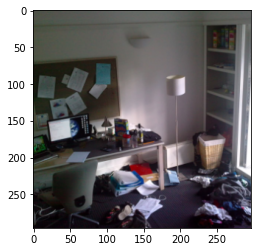

Predicted = Messy, Actual = Messy


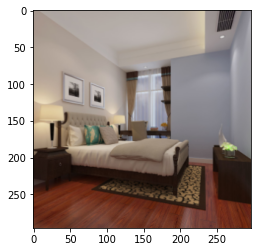

Predicted = Clean, Actual = Clean


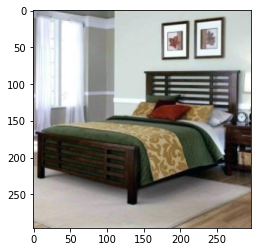

Predicted = Clean, Actual = Clean


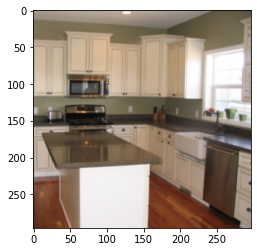

Predicted = Messy, Actual = Clean


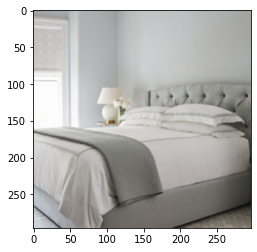

Predicted = Clean, Actual = Clean


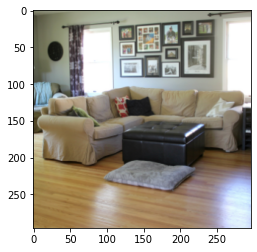

Predicted = Clean, Actual = Clean


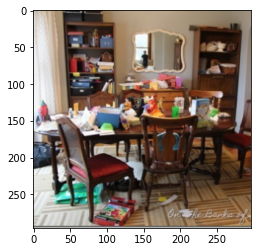

Predicted = Messy, Actual = Messy


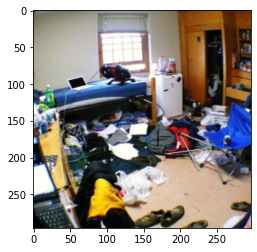

Predicted = Messy, Actual = Messy


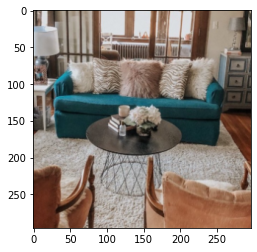

Predicted = Messy, Actual = Clean


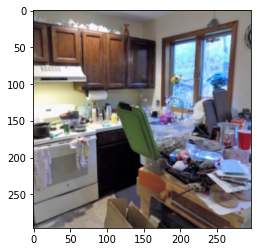

Predicted = Messy, Actual = Messy


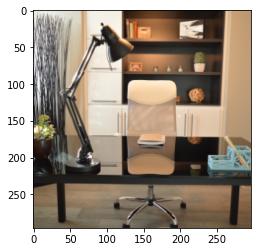

Predicted = Clean, Actual = Clean


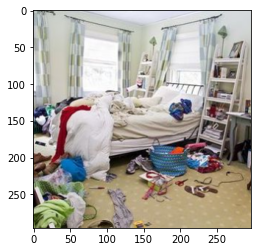

Predicted = Messy, Actual = Messy


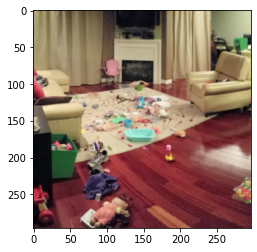

Predicted = Clean, Actual = Messy


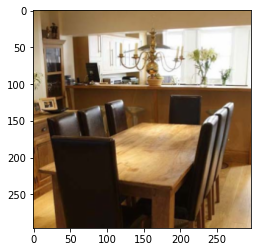

Predicted = Messy, Actual = Clean


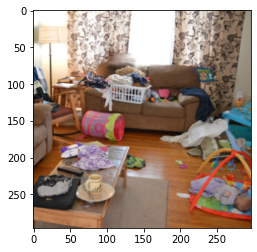

Predicted = Messy, Actual = Messy


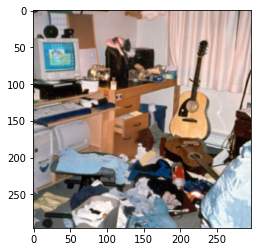

Predicted = Messy, Actual = Messy


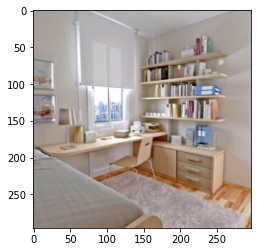

Predicted = Clean, Actual = Clean


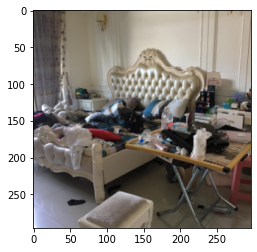

Predicted = Messy, Actual = Messy


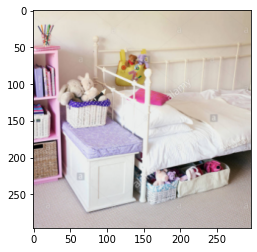

Predicted = Clean, Actual = Clean


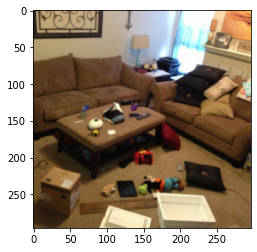

Predicted = Messy, Actual = Messy
	Accuracy = 80.00%
Training Over


In [ ]:
net1 = AlexaNet().to(device)
train(net1, 0.0001, 16, 20, "ADAM" )    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


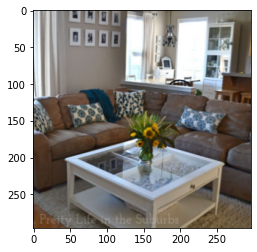

Predicted = Messy


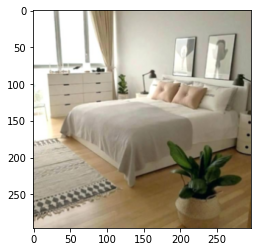

Predicted = Clean


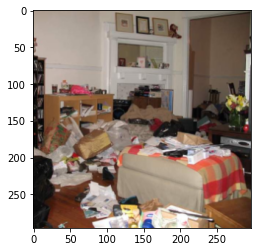

Predicted = Messy


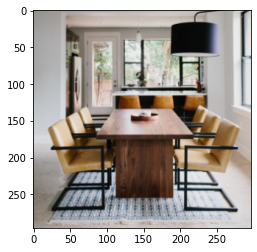

Predicted = Messy


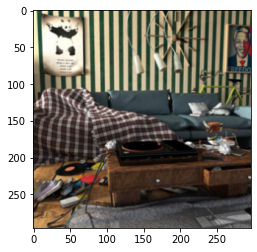

Predicted = Messy


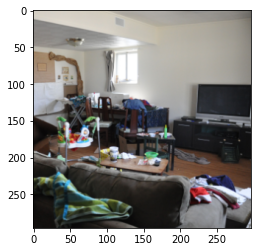

Predicted = Messy


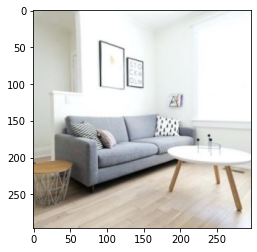

Predicted = Clean


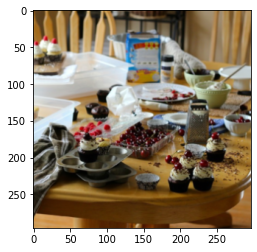

Predicted = Messy


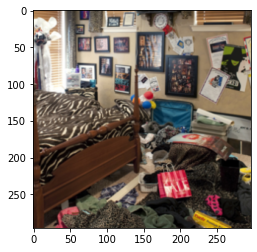

Predicted = Messy


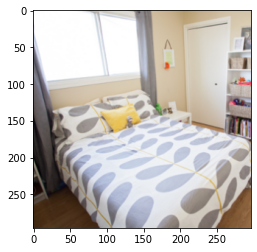

Predicted = Clean


In [ ]:
import torchvision
import torchvision.transforms as transforms

transforms_test = transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize(IMAGE_SIZE),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
test_dataset = BedroonTestDataset("/content/drive/MyDrive/data/Bedroom/test",transforms_test)
test_loader = DataLoader(test_dataset, shuffle=False)
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
      data = data.to(device)

      output = net1(data)
      output = torch.where(output>0.5,1,0)
      predicted = torch.reshape(output,(-1,))
      imshow(torchvision.utils.make_grid(data.cpu()))
      print(f'Predicted = {classes[int(predicted)]}')



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/28] Batch 1/12             loss: 0.6931
Epoch [1/28] Batch 2/12             loss: 0.6973
Epoch [1/28] Batch 3/12             loss: 0.6940
Epoch [1/28] Batch 4/12             loss: 0.6911
Epoch [1/28] Batch 5/12             loss: 0.6910
Epoch [1/28] Batch 6/12             loss: 0.6929
Epoch [1/28] Batch 7/12             loss: 0.6932
Epoch [1/28] Batch 8/12             loss: 0.6845
Epoch [1/28] Batch 9/12             loss: 0.6934
Epoch [1/28] Batch 10/12             loss: 0.6904
Epoch [1/28] Batch 11/12             loss: 0.7044
Epoch [1/28] Batch 12/12             loss: 0.6805
Epoch [2/28] Batch 1/12             loss: 0.6922
Epoch [2/28] Batch 2/12             loss: 0.6773
Epoch [2/28] Batch 3/12             loss: 0.6970
Epoch [2/28] Batch 4/12             loss: 0.7013
Epoch [2/28] Batch 5/12             loss: 0.6773
Epoch [2/28] Batch 6/12             loss: 0.6944
Epoch [2/28] Batch 7/12             loss: 0.6777
Epoch [2/28] Batch 8/12             loss: 0.6780
Epoch [2/28] Batc

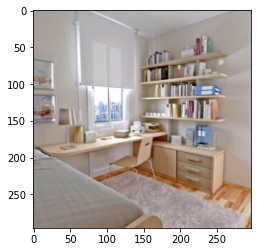

Predicted = Clean, Actual = Clean


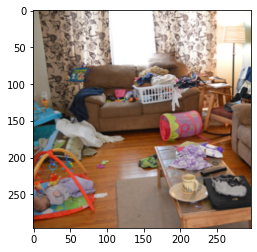

Predicted = Messy, Actual = Messy


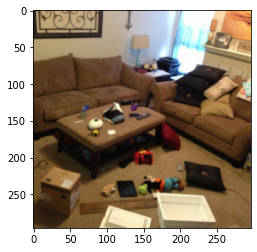

Predicted = Messy, Actual = Messy


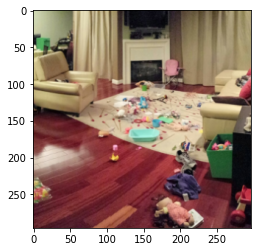

Predicted = Clean, Actual = Messy


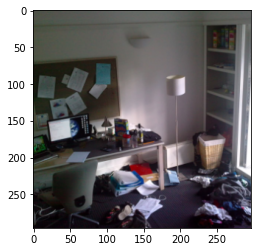

Predicted = Clean, Actual = Messy


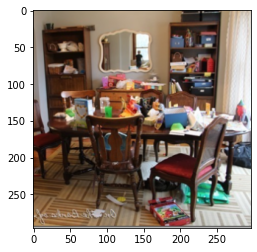

Predicted = Messy, Actual = Messy


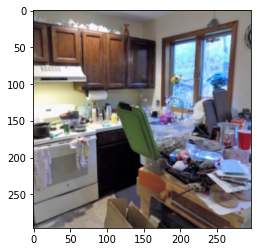

Predicted = Clean, Actual = Messy


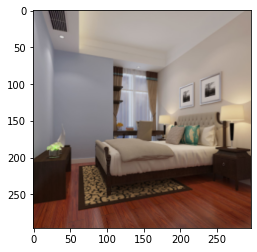

Predicted = Clean, Actual = Clean


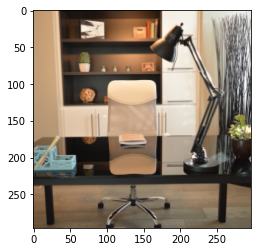

Predicted = Clean, Actual = Clean


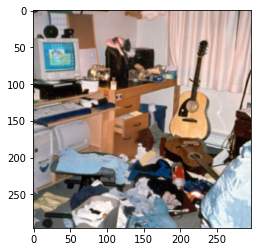

Predicted = Messy, Actual = Messy


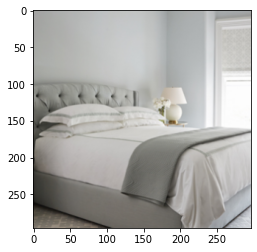

Predicted = Clean, Actual = Clean


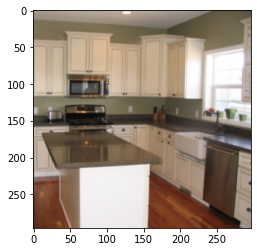

Predicted = Messy, Actual = Clean


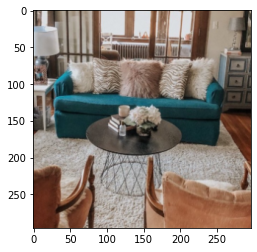

Predicted = Messy, Actual = Clean


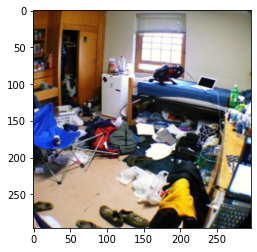

Predicted = Messy, Actual = Messy


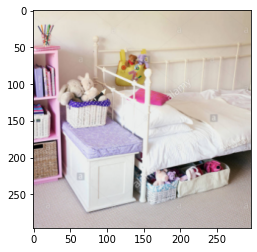

Predicted = Clean, Actual = Clean


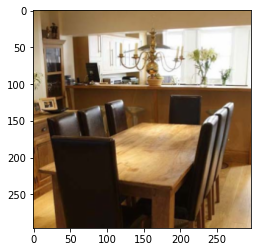

Predicted = Messy, Actual = Clean


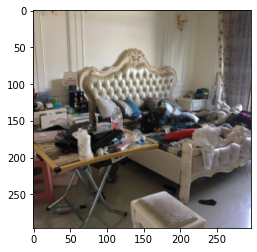

Predicted = Messy, Actual = Messy


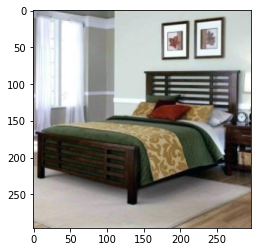

Predicted = Clean, Actual = Clean


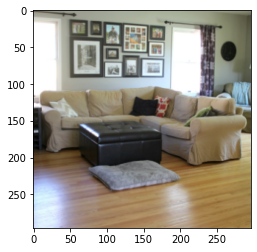

Predicted = Clean, Actual = Clean


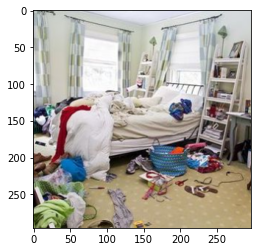

Predicted = Clean, Actual = Messy
	Accuracy = 65.00%
Training Over


In [ ]:
net2 = AlexaNet().to(device)
train(net2, 0.01, 16, 28, "SGD" ) 

Validation


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


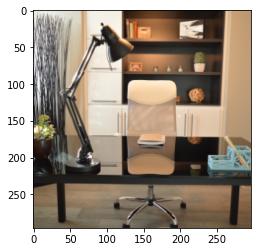

Predicted = Clean, Actual = Clean


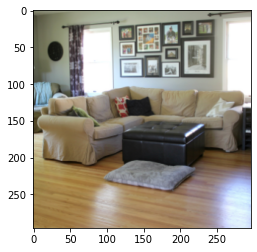

Predicted = Clean, Actual = Clean


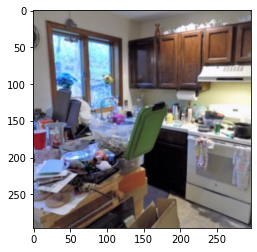

Predicted = Clean, Actual = Messy


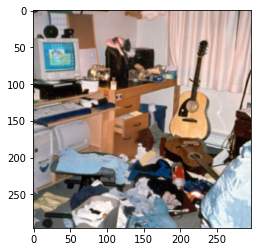

Predicted = Messy, Actual = Messy


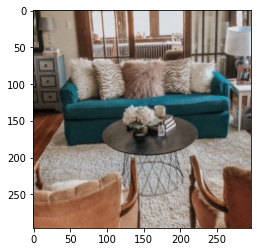

Predicted = Messy, Actual = Clean


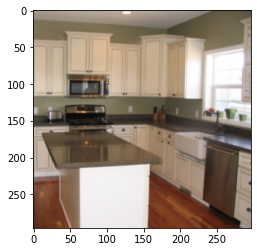

Predicted = Messy, Actual = Clean


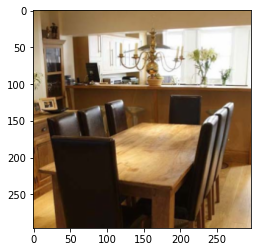

Predicted = Messy, Actual = Clean


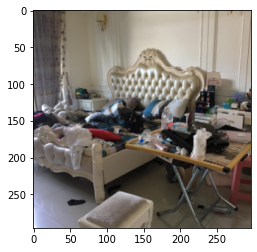

Predicted = Messy, Actual = Messy


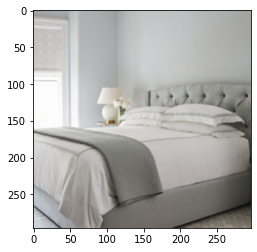

Predicted = Clean, Actual = Clean


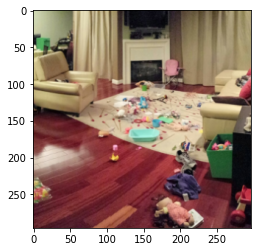

Predicted = Clean, Actual = Messy


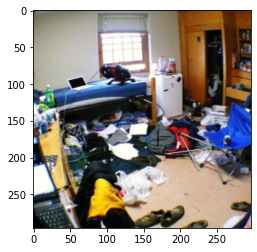

Predicted = Messy, Actual = Messy


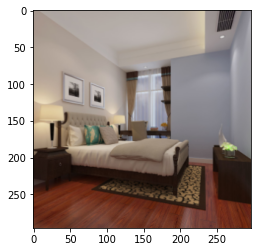

Predicted = Clean, Actual = Clean


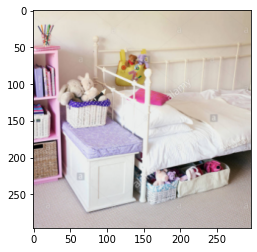

Predicted = Clean, Actual = Clean


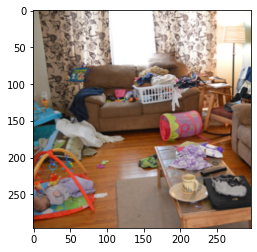

Predicted = Messy, Actual = Messy


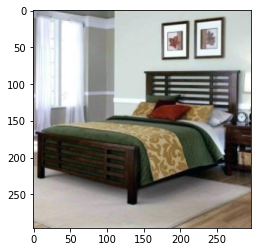

Predicted = Clean, Actual = Clean


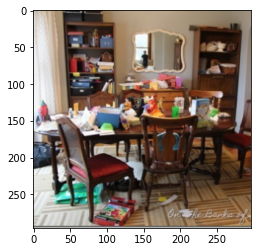

Predicted = Messy, Actual = Messy


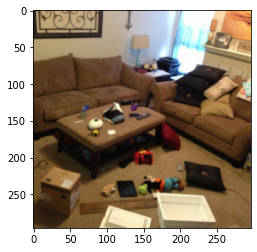

Predicted = Messy, Actual = Messy


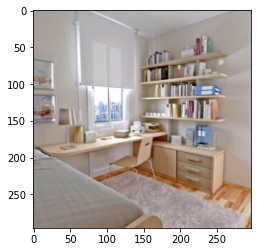

Predicted = Clean, Actual = Clean


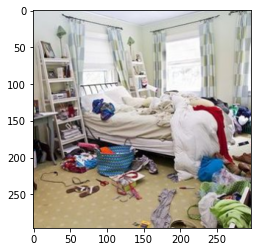

Predicted = Clean, Actual = Messy


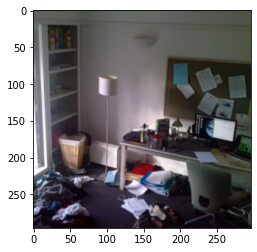

Predicted = Messy, Actual = Messy


tensor(70., device='cuda:0')

In [ ]:
print("Validation")
check_accuracy(valid_loader,net2,show_img = True)

In [ ]:
!zip -r log.zip logs/

In [ ]:
from google.colab import files
files.download("log.zip")

In [ ]:
!rm -rf logs
